In [2]:
pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import wfdb
import ast

In [4]:
import os

In [5]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [6]:
path='/kaggle/input/ecg-data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(os.path.join(path,'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


In [7]:
Y.scp_codes 

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21799, dtype: object

In [8]:
Y.scp_codes.shape

(21799,)

In [9]:
X = load_raw_data(Y, sampling_rate, path)

In [10]:
agg_df = pd.read_csv(os.path.join(path,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


In [11]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [12]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [13]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [14]:
X_train.shape

(19601, 1000, 12)

In [15]:
y_train.head

<bound method NDFrame.head of ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19601, dtype: object>

In [16]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 19601 entries, 1 to 21837
Series name: diagnostic_superclass
Non-Null Count  Dtype 
--------------  ----- 
19601 non-null  object
dtypes: object(1)
memory usage: 306.3+ KB


In [17]:
np.unique(y_train).shape[0]

25

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train_encoded = pd.DataFrame(mlb.fit_transform(y_train), columns=mlb.classes_)

In [19]:
y_train_encoded.shape

(19601, 5)

In [20]:
y_train_encoded.head()

,CD,HYP,MI,NORM,STTC
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [21]:
type(y_train_encoded)

pandas.core.frame.DataFrame

In [22]:
y_train_encoded['final_output']=y_train_encoded.apply(lambda x:''.join(x.astype(str)),axis=1)

In [23]:
y_train_encoded.head()

,CD,HYP,MI,NORM,STTC,final_output
0,0,0,0,1,0,00010
1,0,0,0,1,0,00010
2,0,0,0,1,0,00010
3,0,0,0,1,0,00010
4,0,0,0,1,0,00010


In [24]:
y_train_encoded['final_output'].nunique()

22

In [25]:
y_train_encoded['final_output'].unique()

array(['00010', '00100', '00000', '00001', '01000', '10000', '00101',
       '11000', '10100', '10001', '01100', '01101', '01001', '10101',
       '10010', '11101', '11001', '00011', '11100', '10011', '01010',
       '11110'], dtype=object)

In [26]:
def adjust_classes(y_train):
    var=y_train
    if var == '00010':
        var=0
    elif var == '00100':
        var =1
    elif var== '00000':
        var=2
    elif var=='00001':
        var =3
    elif var =='01000':
        var=4
    elif var=='10000':
        var =5
    elif var =='00101':
        var =6
    elif var =='11000':
        var=7
    elif var =='10100':
        var=8
    elif var=='10001':
        var =9
    elif var =='01100':
        var =10
    elif var =='01101':
        var =11
    elif var=='01001':
        var=21
    elif var =='10101':
        var=12
    elif var =='10010':
        var=13
    elif var=='11101':
        var=14
    elif var=='11001':
        var=15
    elif var =='00011':
        var=16
    elif var=='11100':
        var=17
    elif var=='10011':
        var=18
    elif var =='01010':
        var=19
    elif var=='11110':
        var=20
    return var

In [27]:
y_train_encoded['final_output']=y_train_encoded['final_output'].apply(adjust_classes)

In [28]:
y_train_encoded

,CD,HYP,MI,NORM,STTC,final_output
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0
...,...,...,...,...,...,...
19596,0,0,0,0,1,3
19597,0,0,0,1,0,0
19598,0,0,0,0,1,3
19599,0,0,0,1,0,0


In [29]:
y_train_encoded['final_output'].value_counts()

final_output
0     8157
1     2276
3     2158
5     1524
8     1164
21     708
6      538
4      479
9      433
2      371
13     362
11     320
7      273
12     202
15     186
10     166
14     140
17     112
16      24
18       5
19       2
20       1
Name: count, dtype: int64

In [31]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [32]:
x_train_normalization=X_train.reshape(-1,1000*12)

In [33]:
x_train=scaler.fit_transform(x_train_normalization)
x_train_normalized=x_train.reshape(19601,1000,12)

In [34]:
class_distribution_norm=y_train_encoded['NORM'].value_counts()

In [35]:
class_distribution_cd=y_train_encoded['CD'].value_counts()

In [36]:
class_distribution_hyp=y_train_encoded['HYP'].value_counts()

In [37]:
class_distribution_mi=y_train_encoded['MI'].value_counts()

In [38]:
class_distribution_sttc=y_train_encoded['STTC'].value_counts()

In [39]:
indices_0 = np.where(y_train_encoded['NORM'] == 0)[0] 
indices_1 = np.where(y_train_encoded['NORM'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 996, 64)        │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 996, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 996, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 994, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 994, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 994, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 497, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 495, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 495, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 495, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 247, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 245, 512)       │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 245, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 245, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 122, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,089 (2.63 MB)

 Trainable params: 687,169 (2.62 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7183 - loss: 0.9754 - val_accuracy: 0.7812 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8368 - loss: 0.6655 - val_accuracy: 0.7676 - val_loss: 0.7545 - learning_rate: 0.0010
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8571 - loss: 0.5765 - val_accuracy: 0.7227 - val_loss: 0.8216 - learning_rate: 0.0010
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8721 - loss: 0.5100 - val_accuracy: 0.8027 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8590 - loss: 0.4639 - val_accuracy: 0.8594 - val_loss: 0.5111 - learning_rate: 0.0010
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8757 - loss: 0.4285 - val_accuracy: 0.8613 - val_loss: 0.6297 - learning_rate: 0.0010
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8624 - loss: 0.4293 -

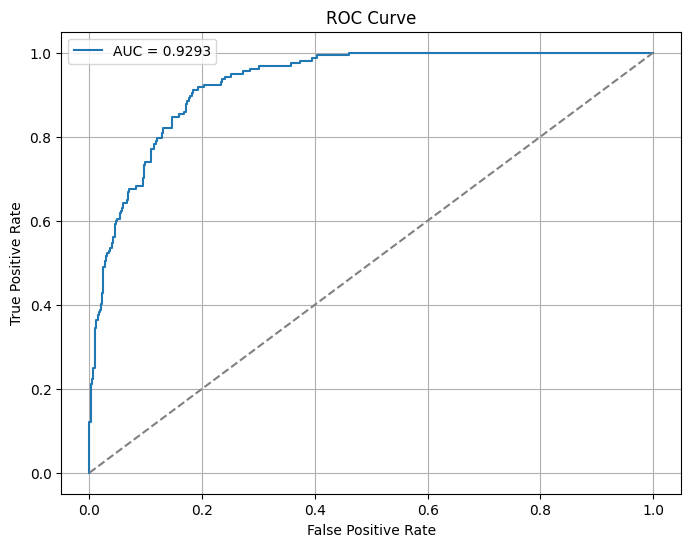

In [60]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def create_ecg_cnn_model(input_shape):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv1D(filters=64, kernel_size=5, activation=None, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Conv1D(filters=128, kernel_size=3, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Conv1D(filters=256, kernel_size=3, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling1D(pool_size=2))
    
    model.add(layers.Conv1D(filters=512, kernel_size=3, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.MaxPooling1D(pool_size=2))
    
    # Global pooling and dense layers
    model.add(layers.GlobalAveragePooling1D())
    
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize the model
input_shape = (1000, 12)
model = create_ecg_cnn_model(input_shape)
model.summary()

# Define callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
x_train, x_test, y_train, y_test = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42
    )

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict probabilities and labels
y_pred_probs = model.predict(x_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:")
print(cm)

# Classification report
cr = classification_report(y_test, y_pred_labels)
print("Classification Report:")
print(cr)

# AUC-ROC
auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8403 - loss: 0.4612 - val_accuracy: 0.8562 - val_loss: 0.4134 - learning_rate: 2.5000e-04
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8623 - loss: 0.4049 - val_accuracy: 0.8742 - val_loss: 0.3754 - learning_rate: 2.5000e-04
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8695 - loss: 0.3696 - val_accuracy: 0.8750 - val_loss: 0.3704 - learning_rate: 2.5000e-04
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8748 - loss: 0.3553 - val_accuracy: 0.8523 - val_loss: 0.3748 - learning_rate: 2.5000e-04
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8732 - loss: 0.3461 - val_accuracy: 0.8578 - val_loss: 0.3626 - learning_rate: 2.5000e-04
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8791 - loss: 0.3304 - val_accuracy: 0.8805 - val_loss: 0.3436 - learning_rate: 2.5000e-04
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/ste

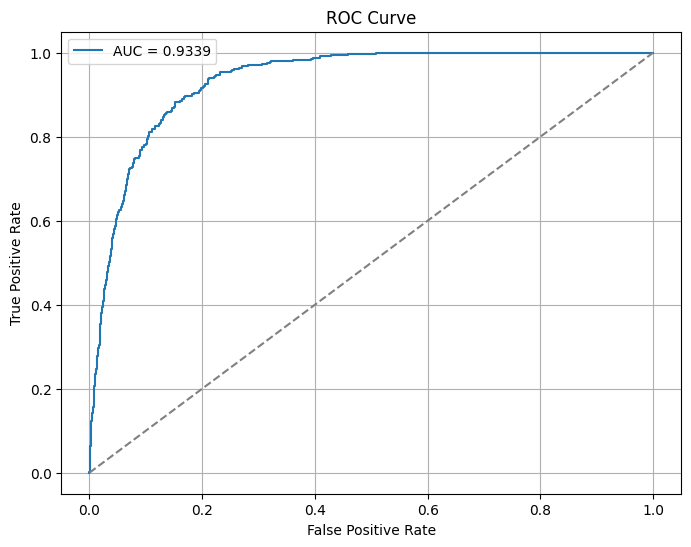

In [62]:
indices_0 = np.where(y_train_encoded['CD'] == 0)[0] 
indices_1 = np.where(y_train_encoded['CD'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
x_train, x_test, y_train, y_test = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42
    )

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict probabilities and labels
y_pred_probs = model.predict(x_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:")
print(cm)

# Classification report
cr = classification_report(y_test, y_pred_labels)
print("Classification Report:")
print(cr)

# AUC-ROC
auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8752 - loss: 0.3347 - val_accuracy: 0.8922 - val_loss: 0.2629 - learning_rate: 6.2500e-05
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8889 - loss: 0.2889 - val_accuracy: 0.9062 - val_loss: 0.2487 - learning_rate: 6.2500e-05
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8933 - loss: 0.2782 - val_accuracy: 0.9008 - val_loss: 0.2512 - learning_rate: 6.2500e-05
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8901 - loss: 0.2822 - val_accuracy: 0.9016 - val_loss: 0.2539 - learning_rate: 6.2500e-05
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8897 - loss: 0.2769 - val_accuracy: 0.9086 - val_loss: 0.2441 - learning_rate: 6.2500e-05
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8946 - loss: 0.2854 - val_accuracy: 0.9078 - val_loss: 0.2437 - learning_rate: 6.2500e-05
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/ste

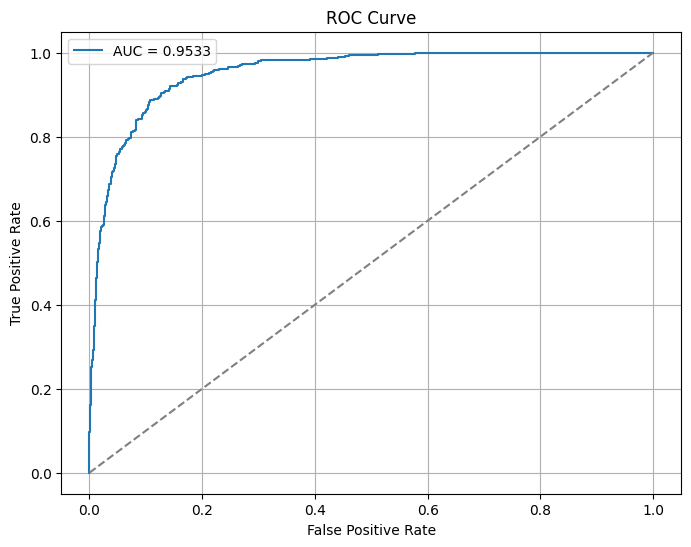

In [63]:
indices_0 = np.where(y_train_encoded['STTC'] == 0)[0] 
indices_1 = np.where(y_train_encoded['STTC'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
input_shape = (1000, 12, 1)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
x_train, x_test, y_train, y_test = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42
    )

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict probabilities and labels
y_pred_probs = model.predict(x_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:")
print(cm)

# Classification report
cr = classification_report(y_test, y_pred_labels)
print("Classification Report:")
print(cr)

# AUC-ROC
auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8940 - loss: 0.2771 - val_accuracy: 0.8961 - val_loss: 0.2570 - learning_rate: 7.8125e-06
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8858 - loss: 0.2831 - val_accuracy: 0.8945 - val_loss: 0.2534 - learning_rate: 7.8125e-06
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8875 - loss: 0.2742 - val_accuracy: 0.8945 - val_loss: 0.2520 - learning_rate: 7.8125e-06
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8858 - loss: 0.2905 - val_accuracy: 0.8945 - val_loss: 0.2503 - learning_rate: 7.8125e-06
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8877 - loss: 0.2748 - val_accuracy: 0.8961 - val_loss: 0.2489 - learning_rate: 7.8125e-06
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9007 - loss: 0.2518 - val_accuracy: 0.8969 - val_loss: 0.2460 - learning_rate: 7.8125e-06
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/ste

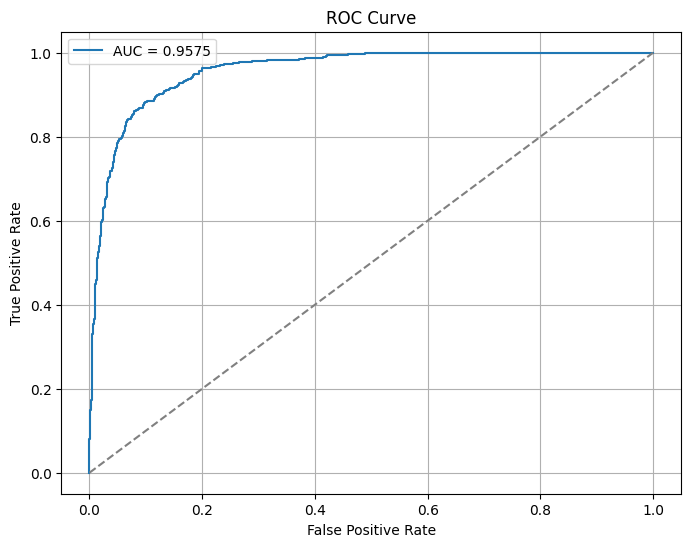

In [64]:
indices_0 = np.where(y_train_encoded['MI'] == 0)[0] 
indices_1 = np.where(y_train_encoded['MI'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 4000, replace=False)
selected_indices_1=np.random.choice(indices_1, 4000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
input_shape = (1000, 12, 1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
x_train, x_test, y_train, y_test = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42
    )

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict probabilities and labels
y_pred_probs = model.predict(x_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:")
print(cm)

# Classification report
cr = classification_report(y_test, y_pred_labels)
print("Classification Report:")
print(cr)

# AUC-ROC
auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8873 - loss: 0.2749 - val_accuracy: 0.8891 - val_loss: 0.2618 - learning_rate: 1.0000e-06
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8944 - loss: 0.2656 - val_accuracy: 0.8938 - val_loss: 0.2568 - learning_rate: 1.0000e-06
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9028 - loss: 0.2474 - val_accuracy: 0.8984 - val_loss: 0.2514 - learning_rate: 1.0000e-06
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9058 - loss: 0.2462 - val_accuracy: 0.9000 - val_loss: 0.2469 - learning_rate: 1.0000e-06
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9065 - loss: 0.2350 - val_accuracy: 0.9000 - val_loss: 0.2436 - learning_rate: 1.0000e-06
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9059 - loss: 0.2422 - val_accuracy: 0.9016 - val_loss: 0.2403 - learning_rate: 1.0000e-06
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 

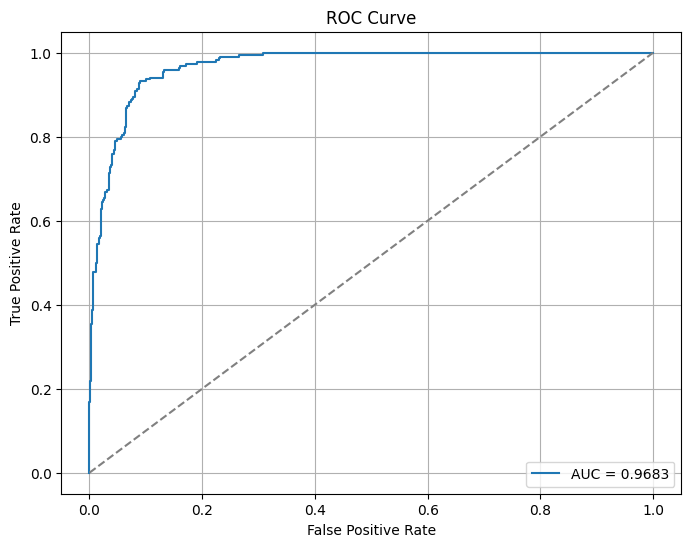

In [65]:
indices_0 = np.where(y_train_encoded['HYP'] == 0)[0] 
indices_1 = np.where(y_train_encoded['HYP'] == 1)[0]
selected_indices_0=np.random.choice(indices_0, 2000, replace=False)
selected_indices_1=np.random.choice(indices_1, 2000, replace=False)
x_train_norm0=X_train[selected_indices_0]
x_train_norm1=X_train[selected_indices_1]
y_train_norm0=y_train_encoded.iloc[selected_indices_0,3]
y_train_norm1=y_train_encoded.iloc[selected_indices_1,3]
x_train= np.concatenate([x_train_norm0, x_train_norm1], axis=0)
y_train=np.concatenate([y_train_norm0, y_train_norm1], axis=0)
input_shape = (1000, 12, 1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
x_train, x_test, y_train, y_test = train_test_split(
        x_train, y_train, test_size=0.2, random_state=42
    )

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict probabilities and labels
y_pred_probs = model.predict(x_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
print("Confusion Matrix:")
print(cm)

# Classification report
cr = classification_report(y_test, y_pred_labels)
print("Classification Report:")
print(cr)

# AUC-ROC
auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC Score: {auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()
